# Traitement des données G353 7m+12m N2H+

In [1]:
%pylab inline
from astropy.io import fits
import aplpy
from pywavan import fbm2d, powspec, fan_trans
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


***
# Verification des données enregistré

In [2]:
im_g = np.load("/user/workdir/soldanof/data/G353/gau.npy")
im_ng = np.load("/user/workdir/soldanof/data/G353/coh.npy")

Text(0.5, 1.0, 'Coherent')

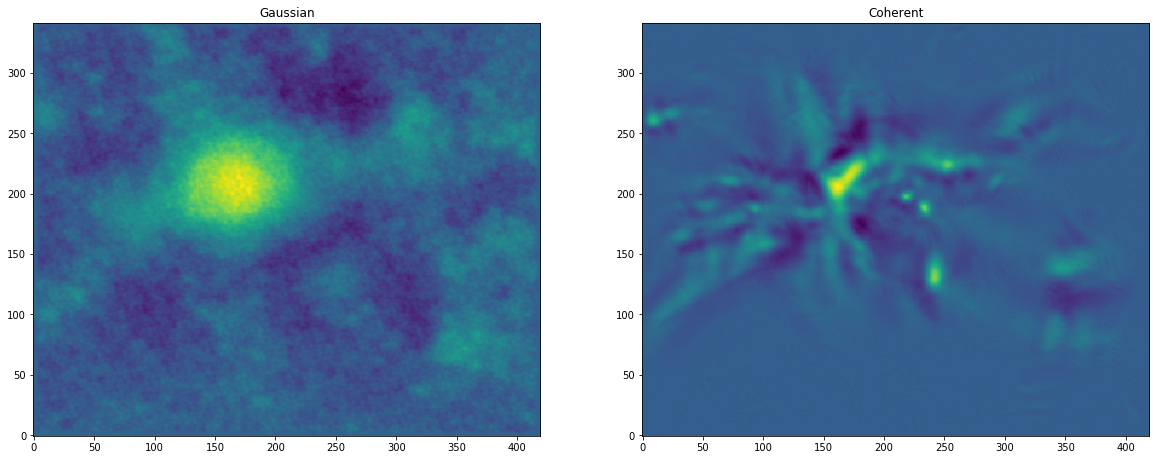

In [3]:
figure(figsize=(20,10))

subplot(1,2,1)
imshow(im_g[50].real,origin="lower")
title('Gaussian')

subplot(1,2,2)
imshow(im_ng[50].real,origin="lower")
title('Coherent')

***
4 image de la partie cohérente à différente partie du cube de donnée

Text(0.5, 1.0, 'canal 100')

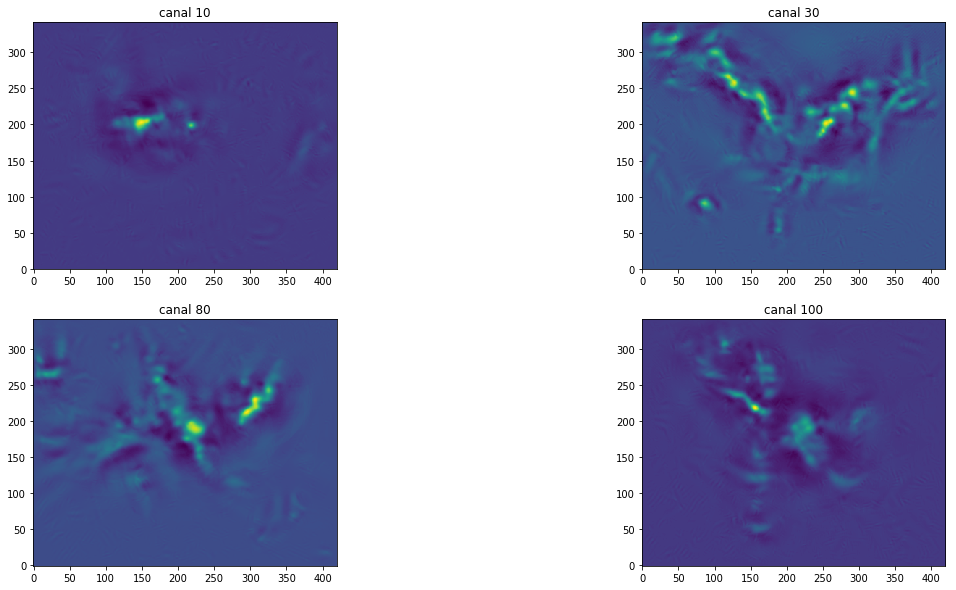

In [5]:
figure(figsize=(20,10))

subplot(2,2,1)
imshow(im_ng[10].real,origin="lower")
title('canal 10')

subplot(2,2,2)
imshow(im_ng[30].real,origin="lower")
title('canal 30')

subplot(2,2,3)
imshow(im_ng[80].real,origin="lower")
title('canal 80')

subplot(2,2,4)
imshow(im_ng[100].real,origin="lower")
title('canal 100')

***
# Transformation des données en fichier fits

In [6]:
HDU = fits.open("/user/workdir/soldanof/ALMA/G353.41_B3_spw0_7M12M_n2hp.image_cut.fits")
cube = HDU[0].data
header = HDU[0].header

In [7]:
fits.writeto("/user/workdir/soldanof/data/G353/ng.fits",im_ng.real, header) 

In [8]:
fits.writeto("/user/workdir/soldanof/data/G353/gau.fits",im_g.real, header) 

***
# Traitement des fichier créé

Trace d'une image

INFO: Auto-setting vmin to -1.216e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.171e-01 [aplpy.core]


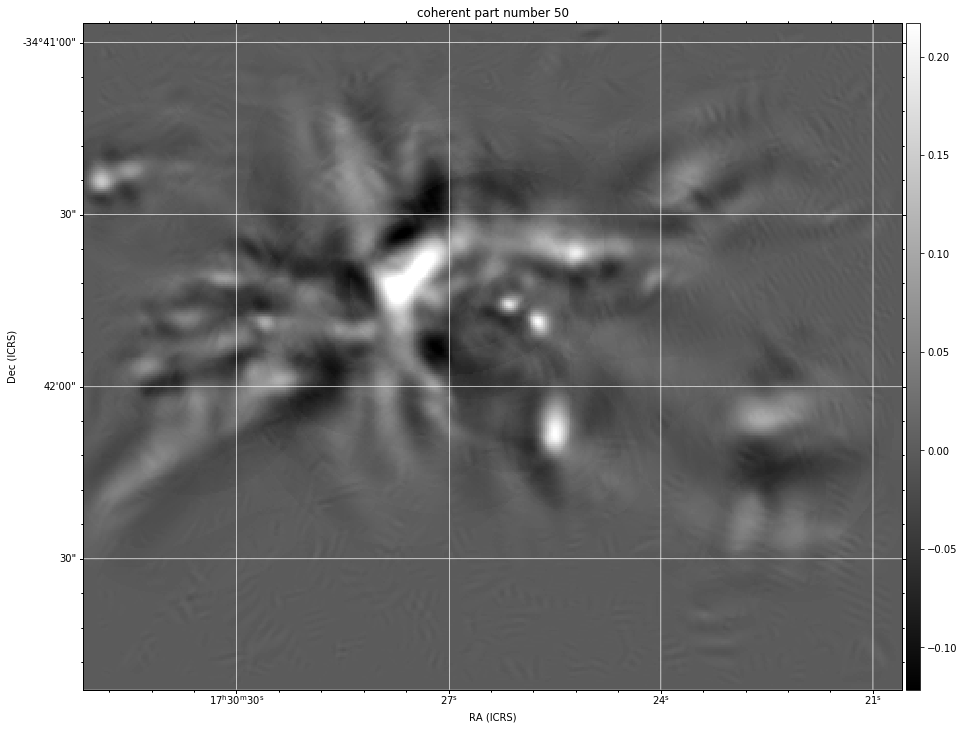

In [10]:
fig_all = plt.figure(1, figsize=(15,15))
nbr = 50
fig = aplpy.FITSFigure("/user/workdir/soldanof/data/G353/ng.fits",figure=fig_all,slices=[nbr])
fig.show_colorscale(cmap='gray')
fig.add_colorbar()
fig.add_grid()
fig.set_title("coherent part number {}".format(nbr))

INFO: Auto-setting vmin to -1.271e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.696e-01 [aplpy.core]


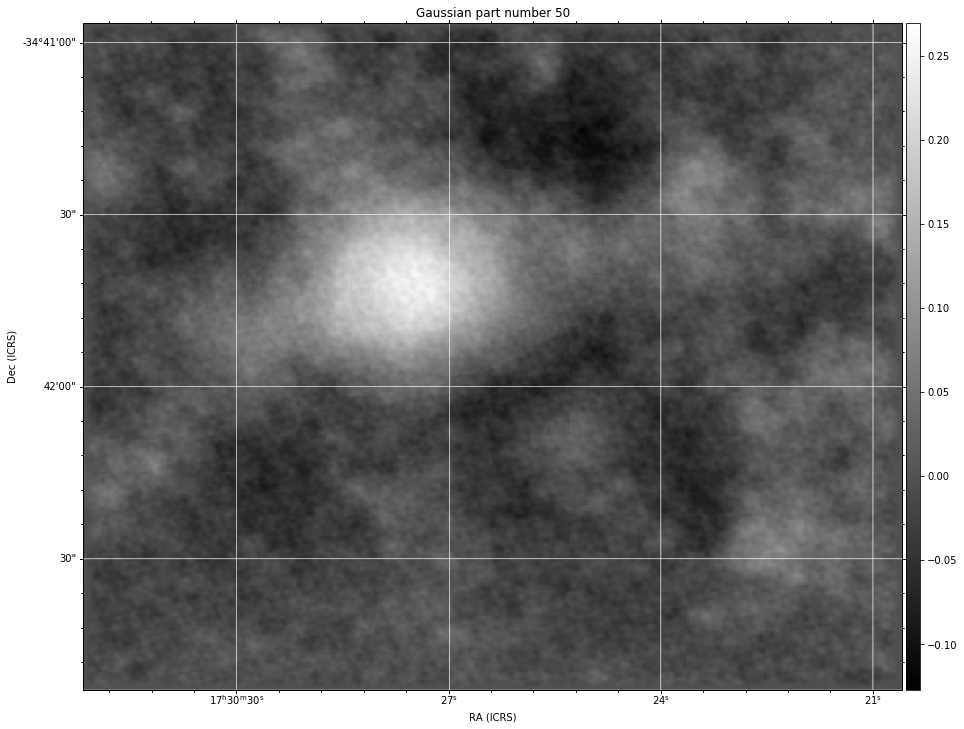

In [11]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure("/user/workdir/soldanof/data/G353/gau.fits",figure=fig_all,slices=[nbr])
fig.show_colorscale(cmap='gray')
fig.add_colorbar()
fig.add_grid()
fig.set_title("Gaussian part number {}".format(nbr))

***
Trace Freq en fonction de Ra pour la partie gaussienne et la partie cohérente

INFO: Auto-setting vmin to -9.610e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.904e-02 [aplpy.core]


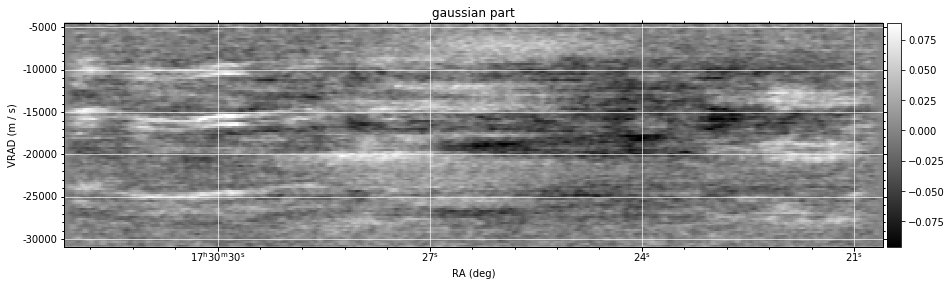

In [64]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure("/user/workdir/soldanof/data/G353/gau.fits",figure=fig_all,dimensions=[0,2],slices=[150])
fig.show_colorscale(cmap='gray')
fig.add_colorbar()
fig.add_grid()
fig.set_title("gaussian part")

INFO: Auto-setting vmin to -1.013e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.120e-01 [aplpy.core]


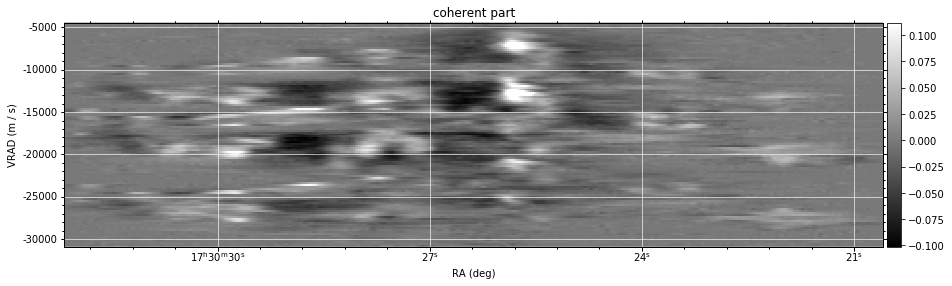

In [63]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure("/user/workdir/soldanof/data/G353/ng.fits",figure=fig_all,dimensions=[0,2],slices=[150])
fig.show_colorscale(cmap='gray')
fig.add_colorbar()
fig.add_grid()
fig.set_title("coherent part")

***
# creation carte intégré (moment 0)

In [14]:
im_ng.shape

(115, 342, 420)

In [15]:
im_ng_int = np.sum(im_ng,axis=0)

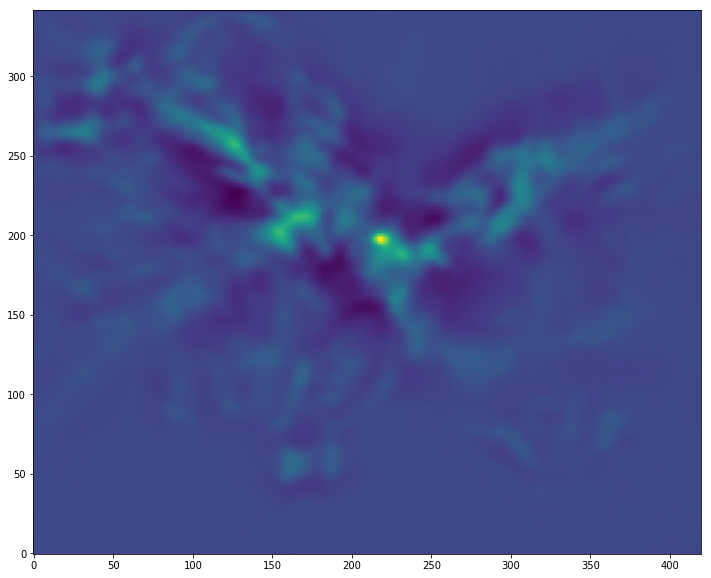

In [24]:
figure(figsize=(20,10))
imshow(im_ng_int.real,origin="lower")

In [17]:
im_tot_int = np.sum(cube,axis=0)

Text(0.5, 1.0, 'moment 0 original cube')

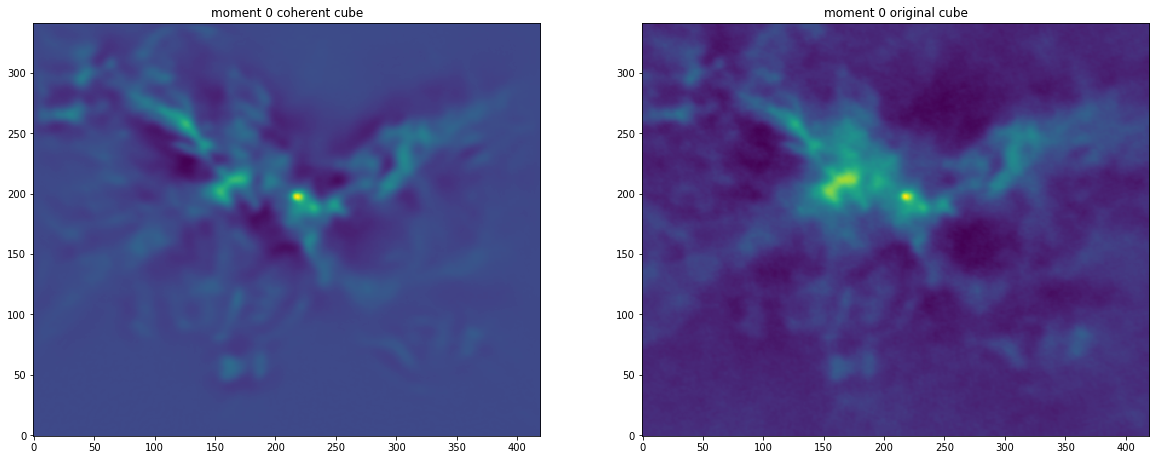

In [74]:
figure(figsize=(20,10))

subplot(1,2,1)
imshow(im_ng_int.real,origin="lower")
title('moment 0 coherent cube')

subplot(1,2,2)
imshow(im_tot_int.real,origin="lower")
title('moment 0 original cube') 

In [19]:
header_t = header
header_t['NAXIS3'] = 1
fits.writeto("/user/workdir/soldanof/data/G353/ng_t.fits",im_ng_int.real, header_t) 

***
# Traitement des donnée du spectre de puissance

In [20]:
t = np.load("/user/workdir/soldanof/data/G353/s1at.npy")
g = np.load("/user/workdir/soldanof/data/G353/s1ag.npy")
ng = np.load("/user/workdir/soldanof/data/G353/s1ang.npy")
w_k = np.load("/user/workdir/soldanof/data/G353/wave_k.npy")

Fonction de trace du spectre de puissance

In [21]:
def affiche(n) :
    plt.plot(w_k, t[n],label="total")
    plt.plot(w_k, g[n],"o",label="gaussian")
    plt.plot(w_k, ng[n],"x",label="non gaussian")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(n)
    plt.legend()

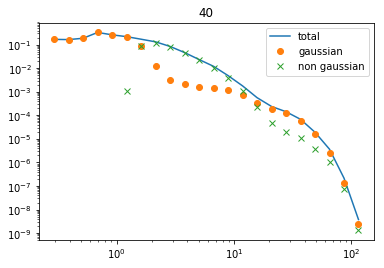

In [25]:
affiche(40)

Text(0.5, 1.0, 'canal 100')

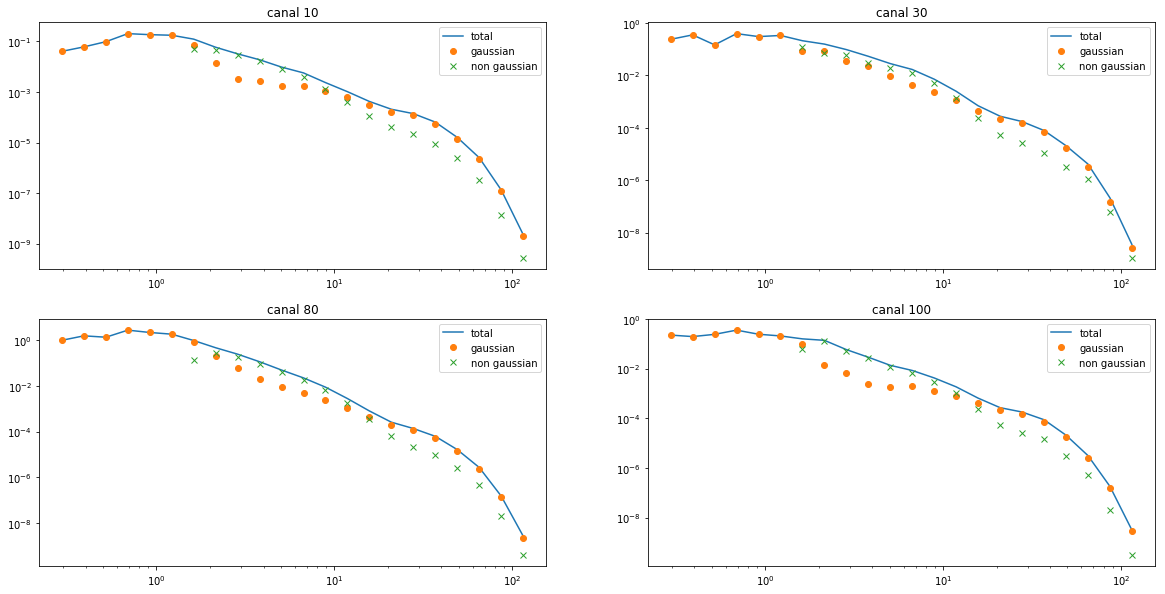

In [73]:

figure(figsize=(20,10))

subplot(2,2,1)
affiche(10)
title('canal 10')

subplot(2,2,2)
affiche(30)
title('canal 30')

subplot(2,2,3)
affiche(80)
title('canal 80')

subplot(2,2,4)
affiche(100)
title('canal 100')

***
# test pvextractor

In [26]:
from pvextractor import Path
from pvextractor import extract_pv_slice
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

In [32]:
filname = "/user/workdir/soldanof/data/G353/ng.fits"
HDU = fits.open(filname)
data = HDU[0].data
header = HDU[0].header

In [33]:
w = wcs.WCS(header)

if w.wcs.has_crota() == True:
    del header['CROTA1']
    del header['CROTA2']
    del header['CROTA3']

w = wcs.WCS(header)

In [29]:
w.pixel_to_world(200,230,0)

[<SkyCoord (ICRS): (ra, dec) in deg
     (262.61099326, -34.69291494)>, <Quantity -30779.99999918 m / s>]

In [30]:
p1 = SkyCoord('17:30:25.935 -34:41:45.961', unit=(u.hourangle, u.deg))
w.world_to_pixel(p1,-30779.99999918*u.m / u.s)[0:2]

[array(225.51410564), array(196.27289393)]

***
## coupe 1

In [51]:
p1 = SkyCoord('17:30:29.044 -34:41:19.847', unit=(u.hourangle, u.deg))
skyp1 = w.world_to_pixel(p1,-30779.99999918*u.m / u.s)[0:2]
x1= int(skyp1[0])
y1= int(skyp1[1])

p2 = SkyCoord('17:30:27.490 -34:41:45.552', unit=(u.hourangle, u.deg))
skyp2 = w.world_to_pixel(p2,-30779.99999918*u.m / u.s)[0:2]
x2= int(skyp2[0])
y2= int(skyp2[1])

pt = [(x1,y1),(x2,y2)]
width = 5

path = Path(pt, width=width)
pv_diag = extract_pv_slice(data, path, wcs=w)

INFO: Auto-setting vmin to -2.074e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.634e-01 [aplpy.core]


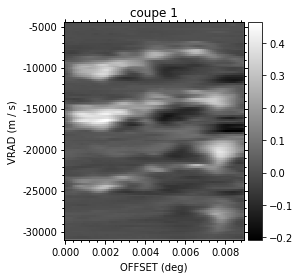

In [52]:
fig_vel = plt.figure(6)
f3 = aplpy.FITSFigure(pv_diag,figure=fig_vel)
f3.show_colorscale(cmap='gray')
f3.set_title("coupe 1")
f3.add_colorbar()

Text(0.5, 1.0, 'moment 0 coherent')

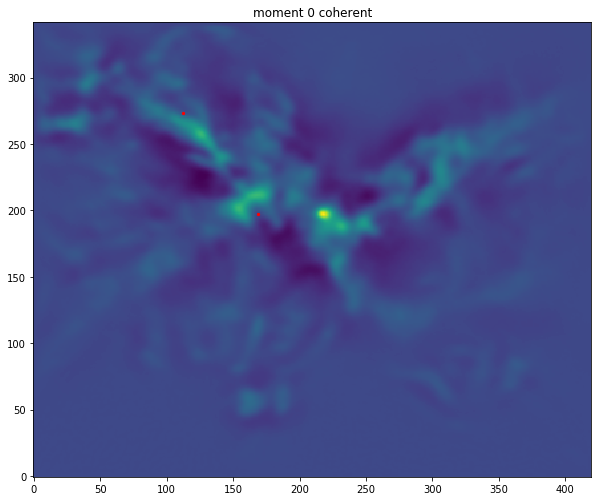

In [57]:
figure(figsize=(10,10))
imshow(im_ng_int.real,origin="lower")

plt.scatter(x1, y1, s=5, c='r', marker='o')
plt.scatter(x2, y2, s=5, c='r', marker='o')

title('moment 0 coherent')

***
## Coupe 2

In [47]:
p1 = SkyCoord('17:30:26.172 -34:41:45.689', unit=(u.hourangle, u.deg))
skyp1 = w.world_to_pixel(p1,-30779.99999918*u.m / u.s)[0:2]
x1= int(skyp1[0])
y1= int(skyp1[1])

p2 = SkyCoord('17:30:25.924 -34:41:56.569', unit=(u.hourangle, u.deg))
skyp2 = w.world_to_pixel(p2,-30779.99999918*u.m / u.s)[0:2]
x2= int(skyp2[0])
y2= int(skyp2[1])

p3 = SkyCoord('17:30:25.289 -34:42:08.128', unit=(u.hourangle, u.deg))
skyp3 = w.world_to_pixel(p3,-30779.99999918*u.m / u.s)[0:2]
x3= int(skyp3[0])
y3= int(skyp3[1])

pt = [(x1,y1),(x2,y2), (x3,y3)]
width = 10

path = Path(pt, width=width)
pv_diag = extract_pv_slice(data, path, wcs=w)

INFO: Auto-setting vmin to -1.105e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.639e-01 [aplpy.core]


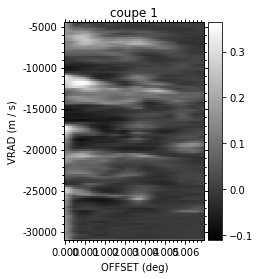

In [48]:
fig_vel = plt.figure(6)
f3 = aplpy.FITSFigure(pv_diag,figure=fig_vel)
f3.show_colorscale(cmap='gray')
f3.set_title("coupe 1")
f3.add_colorbar()

Text(0.5, 1.0, 'moment 0 coherent')

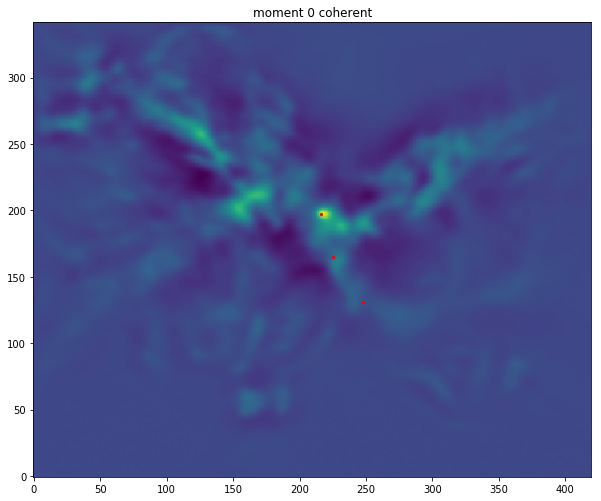

In [49]:
figure(figsize=(10,10))
imshow(im_ng_int.real,origin="lower")

plt.scatter(x1, y1, s=5, c='r', marker='o')
plt.scatter(x2, y2, s=5, c='r', marker='o')
plt.scatter(x3, y3, s=5, c='r', marker='o')

title('moment 0 coherent')